# Project: Seasons and brute force production outcomes in movies

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

I selected the IMDB dataset, since I come from the world of films, having worked in the industry for 20-odd years.The dataset is taken from IMDB by Kaggle, and has been cleaned, apparently because of a request from IMDB. After looking at the dataset in excel, I decided to try and ask some questions that might not be too common, but that could be interesting.

I decided on three questions that would be both challenging and interesting:

>Budgets vs Seasons. How are the production budgets distributed in relation to the season the film will be released in? I suspect the Holiday season will have a relatively large sum of the production budgets. Conversely, I suspect spring to be the all time low. While looking at this question, I also want to investigate if the pattern has changed over time. 

>Do larger budgets yield larger revenues? This will ofcourse be in relation to the cost. So maybe we can find the golden budget range to ensure the largest relative earning.

>Does the frequency of releases have an impact on earnings? From a studio point of view, does it provide a relative advantage to release more titles per year?

Let's get started. 

In [1]:
#I will start by importning the relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()


<a id='wrangling'></a>
## Data Wrangling and Cleaning

To start off, we will have a brief look at the data, and figure out what we need, and what we can get rid off. I will then clean the data, by looking at missing entries, column types and other areas of interest. Lastly, there will be a need to generate a few new dataframes, to make it easier to find the answers to the questions. Though some of this could be done inline, it could prove very complex, and with the dataset of 10.866 rows, it proves very slow to do some of the operations. These dataframes will be saved as csv files and read back in later, so you do not have to re-run those fields.
Although I am aware that we should usually wrangle, then clean, I have chosen to do it in iterations, as the dataset is quite heavy, and purging the rows and columns we dont need speeds things up considerably.

### General Properties
We will investigate the data on the surface, to get a better idea of what we are working with.

In [2]:
#Let us load in the dataset and get an overview.
df = pd.read_csv('tmdb-movies.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

So, as we can see there are 10866 rows with a lot of different data. We will not be using all of these, so let me focus on the columns we need to look at.
### The columns we need...
Since our questions all have to do with budgets, revenues, release dates and production companies, we can single out the columns that seem to make sense for us. This will make the data more managable further down.
We need the title of course, so the original_title columns stays.
For revenue and budget, I have chosen to keep the adjusted versions of these, so we will not be using the actual numbers but the relationship between them. This means that we could choose to keep either the adjusted or original.
Next up, we need the production companies column, the release year and release date. 

So, before we start cleaning, I will get rid of the columns that are not needed to answer our questions. I am dropping the columns in two lines simply to make it easier to follow.

In [3]:
df.drop(['id','imdb_id','popularity','budget','revenue','cast','homepage','director','tagline','keywords','overview'],axis=1, inplace=True)
df.drop(['runtime','genres','vote_count', 'vote_average'], axis=1, inplace=True)
df.head()

,original_title,production_companies,release_date,release_year,budget_adj,revenue_adj
0,Jurassic World,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,2015,1.379999e+08,1.392446e+09
1,Mad Max: Fury Road,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,2015,1.379999e+08,3.481613e+08
2,Insurgent,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2015,1.012000e+08,2.716190e+08
3,Star Wars: The Force Awakens,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,2015,1.839999e+08,1.902723e+09
4,Furious 7,Universal Pictures|Original Film|Media Rights ...,4/1/15,2015,1.747999e+08,1.385749e+09


ok, thats alot cleaner. Let us investigate the data and start cleaning and wrangling.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 6 columns):
original_title          10866 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
release_year            10866 non-null int64
budget_adj              10866 non-null float64
revenue_adj             10866 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 509.4+ KB


A few things spring to mind instantly. First of all, there are about 1000 rows with the production companies missing. We need to look into those. Maybe we need to fill them in with something, or maybe we can live without them. Second, the release_date needs to be converted to dates, and then from there, it would make sense to create a column for seasons of each release, as we will need to look at that to answer our questions. First off, we will look into the missing production companies...

,release_year,budget_adj,revenue_adj
count,1030.000000,1.030000e+03,1.030000e+03
mean,2005.296117,8.922093e+05,5.730185e+05
std,9.610626,4.299264e+06,4.495947e+06
min,1961.000000,0.000000e+00,0.000000e+00
25%,2002.000000,0.000000e+00,0.000000e+00
50%,2008.000000,0.000000e+00,0.000000e+00
75%,2012.000000,0.000000e+00,0.000000e+00
max,2015.000000,8.393668e+07,7.697178e+07


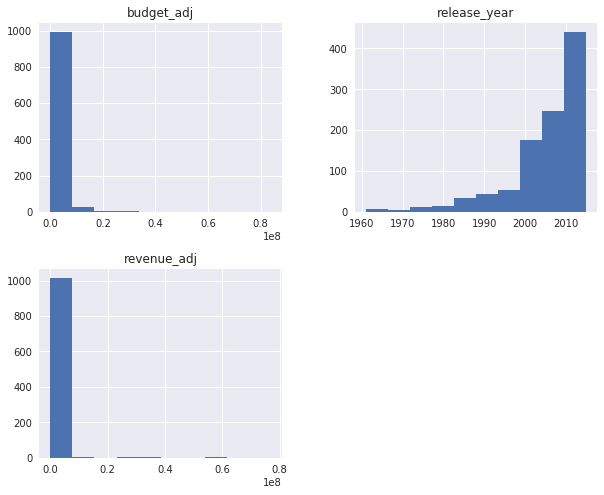

In [5]:
#Let us have a quick look at the rows where production companies is null

df[df.production_companies.isnull()].hist(figsize=(10,8))
df[df.production_companies.isnull()].describe()

Looking at the graphs and numbers, we can see that the majority of our rows with missing production companies, also have missing budgets and revenues. So, to avoid having to go look for all the data manually, I choose to drop those rows. It is also a reminder that we need to drop the rows where budget and revenue are 0, for all of the dataframe, as we need that data to answer our questions, and filling them in with mean values will give us a skewed result. So, time to drop the rows with no production companies, and those with no budget and no revenue.

In [6]:
df.dropna(subset=['production_companies'], inplace=True)
df = df.query('budget_adj != 0').copy()
df = df.query('revenue_adj != 0').copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3809 entries, 0 to 10848
Data columns (total 6 columns):
original_title          3809 non-null object
production_companies    3809 non-null object
release_date            3809 non-null object
release_year            3809 non-null int64
budget_adj              3809 non-null float64
revenue_adj             3809 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 208.3+ KB


It is a bit unfortunate that we have lost more than half of the dataset by now, but at least we are getting closer to some solid data to answer the questions. The next step is to convert the date. To do that, I have to account for the release dates being written with the year shortened, so I am using a VERY crude way to fix this.,

In [7]:
df['release_date'] = df['release_date'].apply(lambda x: (x.split("/")[0]+"/" + x.split("/")[1] + "/20" + x.split("/")[-1] ) if int(x.split("/")[-1]) <= 19 else (x.split("/")[0]+"/" + x.split("/")[1] + "/19" + x.split("/")[-1] )   )
df['release_date'] = pd.to_datetime(df['release_date'], format="%m/%d/%Y")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3809 entries, 0 to 10848
Data columns (total 6 columns):
original_title          3809 non-null object
production_companies    3809 non-null object
release_date            3809 non-null datetime64[ns]
release_year            3809 non-null int64
budget_adj              3809 non-null float64
revenue_adj             3809 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 208.3+ KB


,original_title,production_companies,release_date,release_year,budget_adj,revenue_adj
0,Jurassic World,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,2015,1.379999e+08,1.392446e+09
1,Mad Max: Fury Road,Village Roadshow Pictures|Kennedy Miller Produ...,2015-05-13,2015,1.379999e+08,3.481613e+08
2,Insurgent,Summit Entertainment|Mandeville Films|Red Wago...,2015-03-18,2015,1.012000e+08,2.716190e+08
3,Star Wars: The Force Awakens,Lucasfilm|Truenorth Productions|Bad Robot,2015-12-15,2015,1.839999e+08,1.902723e+09
4,Furious 7,Universal Pictures|Original Film|Media Rights ...,2015-04-01,2015,1.747999e+08,1.385749e+09


Now, let us wrangle the release date to give us a season column. The seasons will be:
>Winter = January and Febuary

>Spring = March and April

>Summer = May through August

>Fall = September and October

>Holidays = November and December

Normally these are defined by events such as Labour Day Weekend, first friday of month etc, but to keep things relatively simple, we are using the months as described above.

In [8]:
seasons = ['Winter','Winter','Spring','Spring','Summer','Summer','Summer','Summer','Fall','Fall','Holidays','Holidays']
month_to_season = dict(zip(range(1,13), seasons))
df['season'] = df['release_date'].dt.month.map(month_to_season)


df.head()

,original_title,production_companies,release_date,release_year,budget_adj,revenue_adj,season
0,Jurassic World,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,2015,1.379999e+08,1.392446e+09,Summer
1,Mad Max: Fury Road,Village Roadshow Pictures|Kennedy Miller Produ...,2015-05-13,2015,1.379999e+08,3.481613e+08,Summer
2,Insurgent,Summit Entertainment|Mandeville Films|Red Wago...,2015-03-18,2015,1.012000e+08,2.716190e+08,Spring
3,Star Wars: The Force Awakens,Lucasfilm|Truenorth Productions|Bad Robot,2015-12-15,2015,1.839999e+08,1.902723e+09,Holidays
4,Furious 7,Universal Pictures|Original Film|Media Rights ...,2015-04-01,2015,1.747999e+08,1.385749e+09,Spring


Getting there! Let's create one more column, showing the revenue by the budget. ie, if the budget and revenue are the same, we need it to be 100, if the movie made money, the value should be more than 100 and if it did not perform at the box office, we need it to be less than 100.

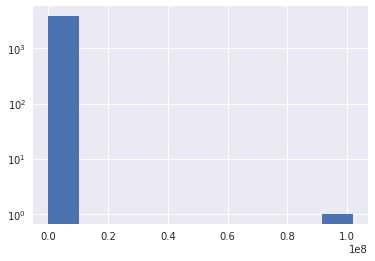

,release_year,budget_adj,revenue_adj,earningFactor
count,3809.000000,3.809000e+03,3.809000e+03,3.809000e+03
mean,2001.234970,4.468275e+07,1.385734e+08,3.015359e+04
std,11.325479,4.487959e+07,2.169279e+08,1.653939e+06
min,1960.000000,9.693980e-01,2.370705e+00,2.400000e-05
25%,1995.000000,1.354637e+07,1.915248e+07,8.880000e+01
50%,2004.000000,3.038360e+07,6.279658e+07,2.130070e+02
75%,2010.000000,6.081498e+07,1.654932e+08,4.216184e+02
max,2015.000000,4.250000e+08,2.827124e+09,1.018619e+08


In [9]:
df['earningFactor'] = df['revenue_adj']/df['budget_adj']*100

plt.hist(df['earningFactor'], log=True) 
plt.show()
df.describe()

It does seem like making movies is a 50/50 chance. We will know more soon. We also need to investigate the max values, as that earning factor seems a bit extreme. 

In [10]:
df.sort_values('earningFactor', ascending=False)

,original_title,production_companies,release_date,release_year,budget_adj,revenue_adj,season,earningFactor
10495,"The Karate Kid, Part II",Columbia Pictures Corporation|Delphi V Product...,1986-06-18,1986,2.248029e+02,2.289886e+08,Summer,1.018619e+08
6179,Into the Night,Universal Pictures,1985-02-15,1985,2.310969e+02,1.358201e+07,Winter,5.877193e+06
3608,From Prada to Nada,Lewis Gilbert Productions|Lionsgate|Modern Vid...,2011-01-28,2011,9.015402e+01,2.423495e+06,Winter,2.688172e+06
7447,Paranormal Activity,Blumhouse Productions|Solana Films,2007-09-14,2007,1.577503e+04,2.033462e+08,Fall,1.289039e+06
2449,The Blair Witch Project,Artisan Entertainment|Haxan Films,1999-07-14,1999,3.272632e+04,3.246451e+08,Summer,9.920000e+05
3581,"Love, Wedding, Marriage",120dB Films|Scion Films|Voodoo Production Serv...,2011-06-03,2011,9.693980e-01,1.335831e+03,Summer,1.378000e+05
1354,Eraserhead,American Film Institute (AFI)|Libra Films,1977-03-19,1977,3.597781e+04,2.518447e+07,Spring,7.000000e+04
7277,Pink Flamingos,Dreamland Productions,1972-03-12,1972,6.257473e+04,3.128737e+07,Spring,5.000000e+04
7178,Super Size Me,Kathbur Pictures,2004-01-17,2004,7.503895e+04,3.298837e+07,Winter,4.396166e+04
242,The Gallows,New Line Cinema|Blumhouse Productions|Manageme...,2015-07-10,2015,9.199996e+04,3.925124e+07,Summer,4.266441e+04


Being a movie person, I can see why we are getting that spike. These films ARE outliers, but they numbers actually seems to hold true. 

The final thing I want to do with the dataset to move on from data wrangling, is splitting the production_companies so that the films will exist once per production company, but we will also keep a row of how many production companies were involved in the film. To make life simpler in the long run, I will save out the current dataframe as cleaned_imdb.csv , and create a seperate dataframe where the production companies are split, and save that to cleaned_production.csv.

In [28]:
#First, let us save the cleaned data
df.to_csv('cleaned_imdb.csv')

#Then we split the production companies.
df_production = pd.DataFrame()
mycount = len(df.index)
#mycount = 140   #This is just to test it quicker. 
for i in range(mycount):
    pc = df.iloc[i].production_companies.split("|")
    df_pc = df.iloc[i].copy()
    for c in pc:
        df_pc['production_company'] = c
        df_pc['producion_company_count'] = len(pc)
        df_production = df_production.append(df_pc, ignore_index=True)

df_grouped = df_production.groupby(['production_company','release_year']).agg({'release_year':'count','revenue_adj':'mean','budget_adj':'mean'}).rename(columns={'release_year':'releases'})

df_grouped.to_csv('productionCompaniesData.csv')
df_grouped.head(10)
df_pro = pd.read_csv('productionCompaniesData.csv')
df_pro.head(15)
                     

,production_company,release_year,releases,revenue_adj,budget_adj
0,"""DIA"" Productions GmbH & Co. KG",2003.0,1,5.257149e+07,4.267270e+07
1,1019 Entertainment,2015.0,1,2.577386e+06,1.839999e+06
2,10th Hole Productions,2010.0,2,1.741484e+07,4.250000e+06
3,10th Hole Productions,2013.0,1,9.982524e+05,5.616200e+06
4,11:11 Mediaworks,2006.0,1,1.289223e+08,2.704173e+07
5,120dB Films,2011.0,1,1.335831e+03,9.693980e-01
6,120dB Films,2013.0,1,9.982524e+05,5.616200e+06
7,1492 Pictures,1996.0,1,1.804952e+08,8.341300e+07
8,1492 Pictures,1999.0,1,1.226583e+08,1.309053e+08
9,1492 Pictures,2001.0,2,6.045899e+08,1.231488e+08


### Data Cleaning and wrangling done!

We now have two files, one to use when answering the third question, and one for the two first ones. They have been cleaned and optimized, so we're ready to go. 

## Getting ready for analysis

To clean things up, I start by reloading the dataset, just to make sure there are no odd legacies hanging around.


In [12]:
df= pd.read_csv('cleaned_imdb.csv')

df.head()

,Unnamed: 0,original_title,production_companies,release_date,release_year,budget_adj,revenue_adj,season,earningFactor
0,0,Jurassic World,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,2015,1.379999e+08,1.392446e+09,Summer,1009.019207
1,1,Mad Max: Fury Road,Village Roadshow Pictures|Kennedy Miller Produ...,2015-05-13,2015,1.379999e+08,3.481613e+08,Summer,252.290903
2,2,Insurgent,Summit Entertainment|Mandeville Films|Red Wago...,2015-03-18,2015,1.012000e+08,2.716190e+08,Spring,268.398365
3,3,Star Wars: The Force Awakens,Lucasfilm|Truenorth Productions|Bad Robot,2015-12-15,2015,1.839999e+08,1.902723e+09,Holidays,1034.089113
4,4,Furious 7,Universal Pictures|Original Film|Media Rights ...,2015-04-01,2015,1.747999e+08,1.385749e+09,Spring,792.762821


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Budgets vs seasons
It's time to look at how the budgets are spent depending on the release season

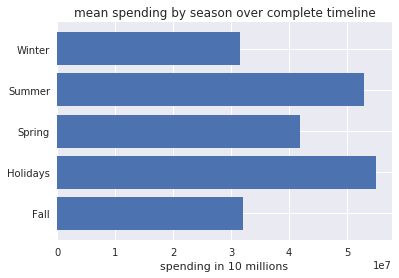

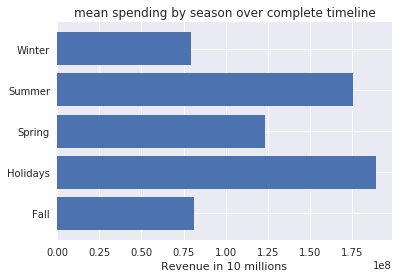

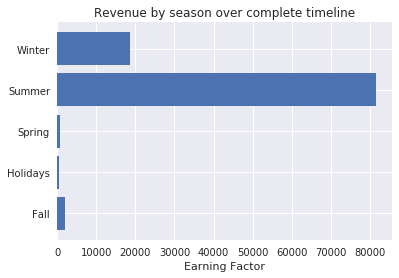

In [13]:
seasongroup = df.groupby(['season']).mean()

#First, a plot for the budgets
plt.barh(seasongroup.index, seasongroup.budget_adj )
plt.title('mean spending by season over complete timeline')
plt.xlabel('spending in 10 millions')
plt.show()

#Then we will look at the revenue by season
plt.barh(seasongroup.index, seasongroup.revenue_adj )
plt.title('mean spending by season over complete timeline')
plt.xlabel('Revenue in 10 millions')
plt.show()

#And lastly the earning factor
plt.barh(seasongroup.index, seasongroup.earningFactor )
plt.title('Revenue by season over complete timeline')
plt.xlabel('Earning Factor')
plt.show()


To make sure we are seeing the correct picture, it would make sense to look at the development of the season spendings over time...

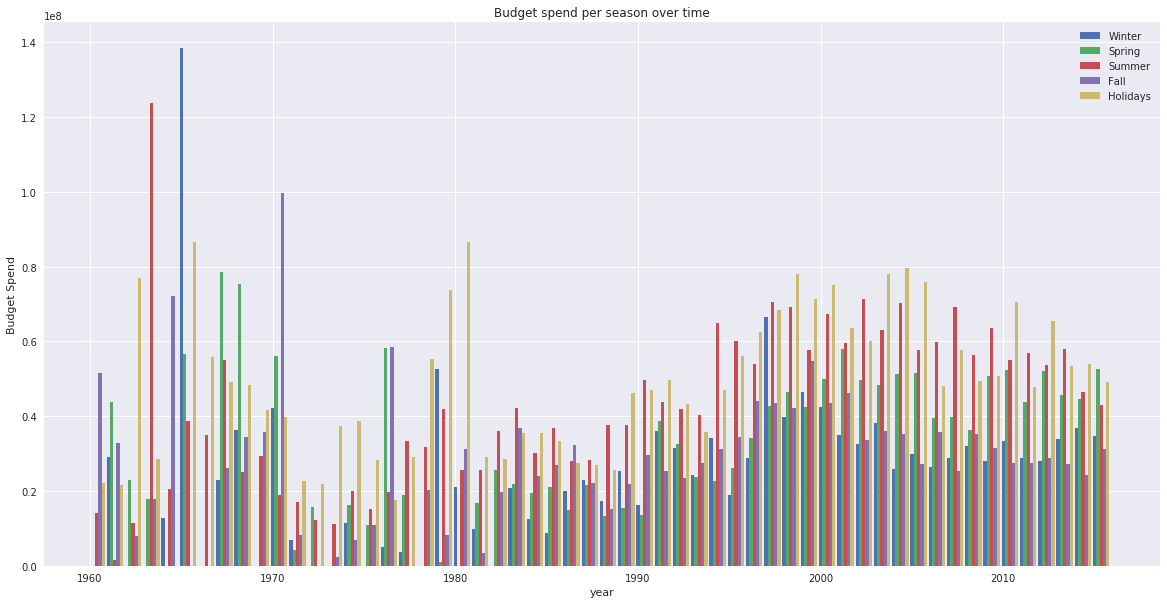

In [14]:
#some housekeeping
width=0.18
plt.figure(figsize=(20,10))

#Get the means for each season
wintermean = df.query('season == "Winter"')
wintermean = wintermean.groupby('release_year').mean()

springmean = df.query('season == "Spring"')
springmean = springmean.groupby('release_year').mean()

summermean = df.query('season == "Summer"')
summermean = summermean.groupby('release_year').mean()

fallmean = df.query('season == "Fall"')
fallmean = fallmean.groupby('release_year').mean()

holidaymean = df.query('season == "Holidays"')
holidaymean = holidaymean.groupby('release_year').mean()

#plot the bars
plt.bar(wintermean.index, wintermean.budget_adj ,width=width, label='Winter')
plt.bar(springmean.index+width, springmean.budget_adj,width=width, label='Spring')
plt.bar(summermean.index+width*2, summermean.budget_adj,width=width, label='Summer')
plt.bar(fallmean.index+width*3, fallmean.budget_adj,width=width, label='Fall')
plt.bar(holidaymean.index+width*4, holidaymean.budget_adj,width=width, label='Holidays')

plt.title('Budget spend per season over time')
plt.xlabel('year')
plt.ylabel('Budget Spend')
plt.legend(loc='best')
plt.show()

So, from this graph it seems that before 1980's movies where not planned as much to the season of release as what started happening in the 80's. There seems to be a trend of the movies released in the holidays are by no small means the most expensive ones. This makes sense, it's always at the holidays we have seen the tentpole features, such as star wars, lord of the rings, avengers etc. There is also a trend on the rise where summer and spring films are increasing in budget, where as fall film release budgets are low, and actaully going down it seems.

### Do larger budgets yield larger revenues?

From a ROI point of view, is it benefitial to make the expensive films? 

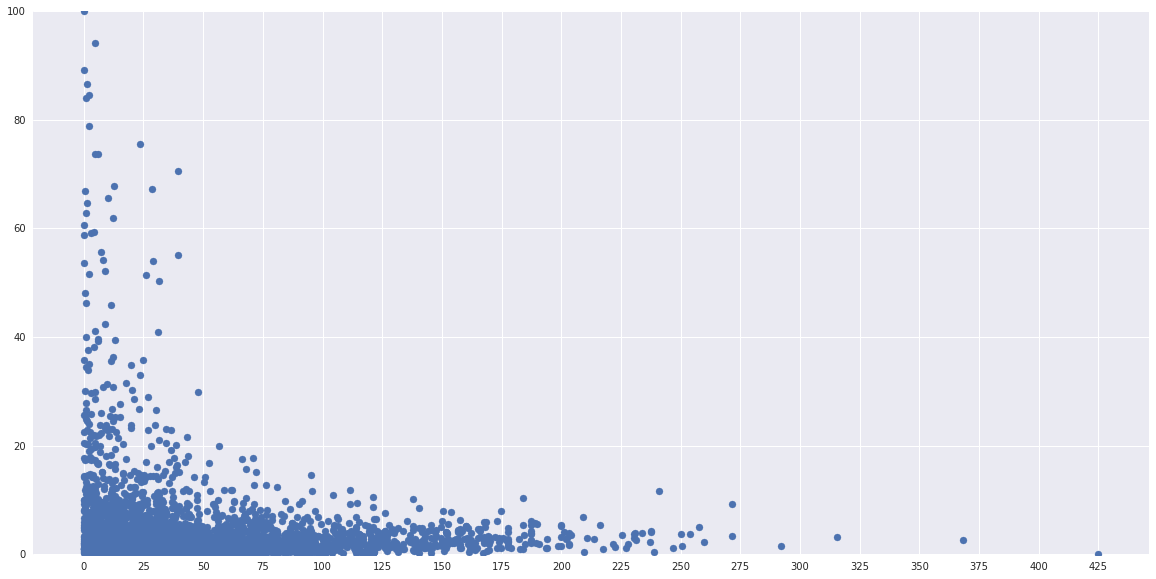

In [15]:
df.head()
plt.figure(figsize=(20,10))
X = df.budget_adj
Y = df.earningFactor

plt.scatter(df.budget_adj/1000000, df.earningFactor/100)
plt.xticks(np.arange(min(df.budget_adj/1000000), max(df.budget_adj/1000000)+1, 25.0))
plt.xlabel('Production Budget')
plt.ylabel('earning rate')
plt.title('Scatterplot of earning rate vs production budget')

#need to limit the y axis, as single outliers are making the graph hard to read.
ax = plt.gca()
ax.set_ylim(-0.1, 100)

plt.show()

As a factor of budget, it seems the sweet spot must be film with production budgets of 25-35 million usd. While earning 30-60 percent on a 400 million dollar movie is a huge amount of money, the risks might not actually be worth it, unless you have a 'sure thing' such as the Marvel Avengers series.

### Does the frequency of releases have an impact on earnings? 

When the big studios release several films every year, does it pay off because of many small wins or are they good enough that all the films are money makers? This is where we will use the other csv file we wrangled.


Text(0,0.5,'earning rate')

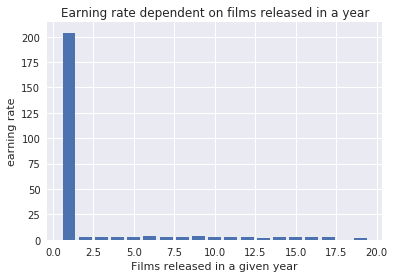

In [47]:
df_pro = pd.read_csv('productionCompaniesData.csv')

#lets add a column for earning factor
df_pro['earningFactor'] = df_pro['revenue_adj']/df_pro['budget_adj']*100

df_pro_res = df_pro.groupby(['releases']).mean()

plt.bar(df_pro_res.index, df_pro_res.earningFactor/100)
plt.title("Earning rate dependent on films released in a year")
plt.xlabel('Films released in a given year')
plt.ylabel('earning rate')


Obviously, including the single film per year production companies makes this graph hard to read, as it includes all sorts of outliers, like the ones we saw in the data wrangling section. So lets do another one, with only two films or more in a given year.

(0, 5)

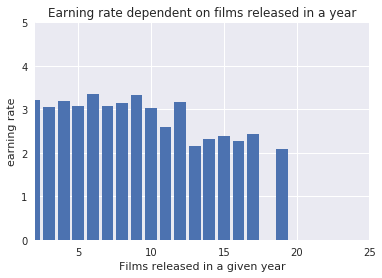

In [51]:
df_pro_res = df_pro.groupby(['releases']).mean()

plt.bar(df_pro_res.index, df_pro_res.earningFactor/100)
plt.title("Earning rate dependent on films released in a year")
plt.xlabel('Films released in a given year')
plt.ylabel('earning rate')
ax = plt.gca()
ax.set_xlim(2, 25)
ax.set_ylim(0, 5)



We could draw a conclusion that just doing one film per year is definetely the best bet, but ofcourse that includes your odd Blair Witch Project and other outliers. What is interesting here is that the earning rate is very close to stable for the first 10 films per year, and then starts to decline, but not radically. Going from 3 times earning to 2 is ofcourse a lot, but it's from almost twice as many films. 

<a id='conclusions'></a>
## Conclusions

Coming from the film industry, I will conclude the following, relevant to film producers.

1) The summer season release is growing. Depending on your budget, you should either exploit the the lower budget and and aim for a fall releasewhere competition is not as steep, or if you have a high budget movie, go and compete in the rising summer season.
2) The sweet spot as regards to budgets is 20-35 million, which is interesting enough, the kinds of movies the studios say they will not make any more.
3) It really doesnt mean much if you produce 1 or 10 films per year.

Now, there are a host of things that could have skewed the data. First of all, I deleted more than half of the data due to lacking entries. Also, I am relying on the adjusted budget and revenue fields, which i actually do not know how were created. And ofcourse there are plenty of other factors that need to be looked at to get a better picture. Nevertheless, this was a very interesting execise.


In [52]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0